# MONKEY CLASSIFICATION
by Durand- -Vegas Johann

MS AIMove Student

The objective of this work is to propose a deep learning algorithm able to classify monkey's images from a dataset composed of individuals belonging to 10 different monkey species. To solve this problem, I suggested to implement a Convolutional Neural Network (CNN).

The dataset used consists of 2 folders, training and validation dataset, respectively composed of 1098 and 272 individuals, and can be found on the Kaggle website, accessible through the link below. 



https://www.kaggle.com/datasets/slothkong/10-monkey-species 

This work has been done in 2 steps, a first "primitive" test in order to have a first view on the performance that can be obtained with a rather simple CNN architecture and raw data. 

Then, a second more elaborated test is proposed which will have allowed to improve the performances of the CNN through the use of several methods (data augmentation, padding, more complex architecture of the model, dropout, ...). 

# INITIALIZATION

First, we start by importing the tools and libraries we will need to load and process the data, create the deep learning model, train it, and finaly, evaluate it. In this work, we will mainly use the tools proposed by keras and tensorflow libraries.

° SETUP

In [ ]:
# Standard libraries
import os 
import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# ML libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Evaluation tools
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

° MOUNTING GOOGLE DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Notice: 

This work having been carried out on Google colab, it was necessary to mount the drive of to be able to reach the training and validation dataset which had been imported beforehand. So, think about adapting the code in order to access your data according to your configuration.

° CREATING PATHS

In [ ]:
# Path definition
Dataset_path = '.'
Dataset_path = '/content/drive/MyDrive/Colab Notebooks/Monkey_Dataset'
assert(os.path.exists(Dataset_path))

Train_path = Dataset_path + '/training/training'
Val_path = Dataset_path + '/validation/validation'

# Path Verification
print('Data Path:', Dataset_path)
print('Train Path:', Train_path)
print('Val path:', Val_path)

Data Path: /content/drive/MyDrive/Colab Notebooks/Monkey_Dataset
Train Path: /content/drive/MyDrive/Colab Notebooks/Monkey_Dataset/training/training
Val path: /content/drive/MyDrive/Colab Notebooks/Monkey_Dataset/validation/validation


In [ ]:
# Visualize labels
Monkey_labels = pd.read_csv(Dataset_path+'/monkey_labels.txt')
print(Monkey_labels)

   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

# 1 _ BASIC TRIAL

° LOAD DATAS

In [ ]:
# Load datas
MD_Train = tf.keras.utils.image_dataset_from_directory(Train_path,seed=123, batch_size=32, image_size=(256, 256))
MD_Val = tf.keras.utils.image_dataset_from_directory(Val_path,seed=123, batch_size=32, image_size=(256, 256))

print('\n', MD_Train.class_names)
print(MD_Val.class_names)

Found 1097 files belonging to 10 classes.
Found 272 files belonging to 10 classes.

 ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


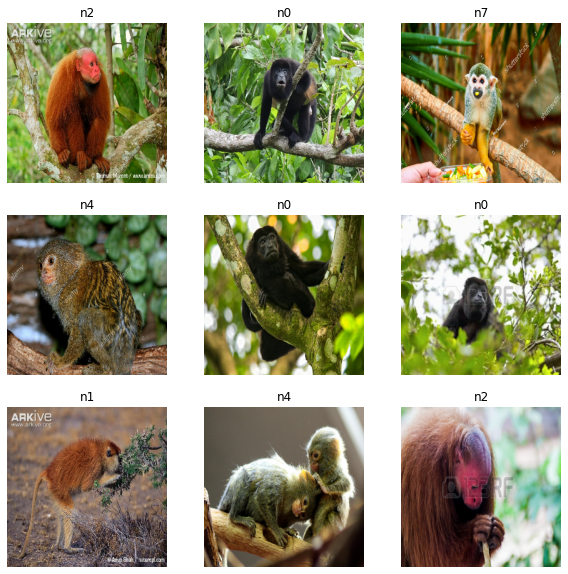

In [ ]:
# Visualize random sample
plt.figure(figsize=(10, 10))
for images, labels in MD_Train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(MD_Train.class_names[labels[i]])
    plt.axis("off")


° DATA NORMALIZATION

In [ ]:
# Normalization of the train dataset
MD_Train_Normalized = MD_Train.map(lambda x, y : (x/255, y))

print("Train Min:", MD_Train_Normalized.as_numpy_iterator().next()[0].min())
print("Train Max:", MD_Train_Normalized.as_numpy_iterator().next()[0].max())
print(f'Nombre de batches // Train: {len(MD_Train_Normalized)}')

# Normalization of the test dataset
MD_Val_Normalized = MD_Val.map(lambda x, y : (x/255, y))

print("Val Min:", MD_Val_Normalized.as_numpy_iterator().next()[0].min())
print("Val Max:", MD_Val_Normalized.as_numpy_iterator().next()[0].max())
print(f'Nombre de batches // Val: {len(MD_Val_Normalized)}')

Train Min: 0.0
Train Max: 1.0
Nombre de batches // Train: 35
Val Min: 0.0
Val Max: 1.0
Nombre de batches // Val: 9


° DEFINE MODEL

In [ ]:
model = Sequential ()

model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

° FIT/TRAIN MODEL

In [ ]:
hist = model.fit(MD_Train_Normalized, epochs=20, validation_data=MD_Val_Normalized)


Epoch 1/20
35/35 [==============================] - 25s 657ms/step - loss: 2.3232 - accuracy: 0.1668 - val_loss: 2.2292 - val_accuracy: 0.2096
Epoch 2/20
35/35 [==============================] - 23s 617ms/step - loss: 1.6079 - accuracy: 0.4394 - val_loss: 1.4057 - val_accuracy: 0.5110
Epoch 3/20
35/35 [==============================] - 22s 600ms/step - loss: 1.1101 - accuracy: 0.6089 - val_loss: 1.3321 - val_accuracy: 0.5515
Epoch 4/20
35/35 [==============================] - 22s 611ms/step - loss: 0.7277 - accuracy: 0.7593 - val_loss: 1.0359 - val_accuracy: 0.6544
Epoch 5/20
35/35 [==============================] - 23s 618ms/step - loss: 0.4888 - accuracy: 0.8441 - val_loss: 1.2679 - val_accuracy: 0.6140
Epoch 6/20
35/35 [==============================] - 22s 611ms/step - loss: 0.1899 - accuracy: 0.9398 - val_loss: 1.5618 - val_accuracy: 0.6434
Epoch 7/20
35/35 [==============================] - 22s 597ms/step - loss: 0.0769 - accuracy: 0.9763 - val_loss: 1.4560 - val_accuracy: 0.6397

° DATA BACKUP

In [ ]:
# Save the model 1 as h5 file
#model.save(os.path.join('/content/drive/MyDrive/Colab Notebooks/Monkey_Saved_Models', 'Monkey_Classifier_Model1.h5'))

# Save histrory of the model 1
#np.save('/content/drive/MyDrive/Colab Notebooks/Monkey_Saved_Models/hist_model.npy',hist)


In [ ]:
# Load the model saved 
#model = load_model('/content/drive/MyDrive/Colab Notebooks/Monkey_Saved_Models/Monkey_Classifier_Model1.h5')

# Load history model 1
#hist = np.load('/content/drive/MyDrive/Colab Notebooks/Monkey_Saved_Models/hist_model.npy',allow_pickle='TRUE').item()


° VISUALIZATION

In [ ]:
# Ultimate score visualization
score = model.evaluate(MD_Val_Normalized, verbose=1)
print(f'Val loss: {score[0]: 4.4f}')
print(f'Val accuracy: {score[1]: 4.4f}')

9/9 [==============================] - 2s 79ms/step - loss: 2.1589 - accuracy: 0.6875
Val loss:  2.1589
Val accuracy:  0.6875


At the end of this first test from a simple architecture CNN and raw data, we quickly see after a few iterations that the model is not performing at all for our classification task. Indeed, the error (Loss) is high (2.16) and the accuracy is only 68.75%, what means about one chance out of 2 to predict the right class of an image. 

By observing the curves of the evolution of the loss and the accuracy according to the number of epochs, we notice indeed that the curves of test do not fit at all to the curves of training.

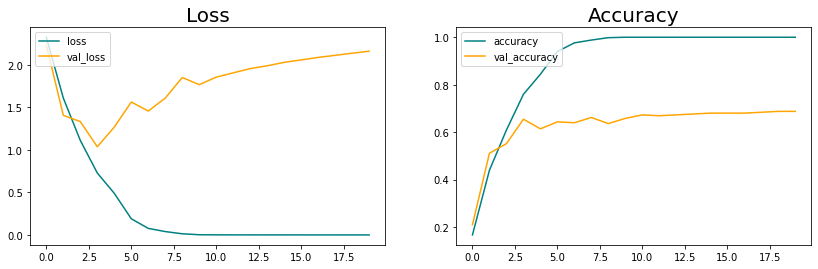

In [ ]:
plt.figure(figsize=(14,4))

# Loss visualization
plt.subplot(1,2,1)
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.title('Loss', fontsize=20)
plt.legend(loc='upper left')

# Accuracy visualisation
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.legend(loc='upper left')

plt.show()

° EVALUATION METRICS

To evaluate the performance of the model, a good method is to display the confusion matrix. That is to say, to highlight whether the values predicted are correct or not, and in which proportion. 

In [ ]:
# Separating Validation dataset into image (X_VAL) and label (y_VAL) datasets
X_VAL, y_VAL = MD_Val_Normalized.as_numpy_iterator().next() #next(MD_Val_Normalized)
#print(y_VAL)

# Predicting 
y_VAL_pred = model.predict(X_VAL).argmax(axis=1)

# Creating a confution matrix
cm = confusion_matrix(y_VAL, y_VAL_pred)
cm_df = pd.DataFrame(cm)

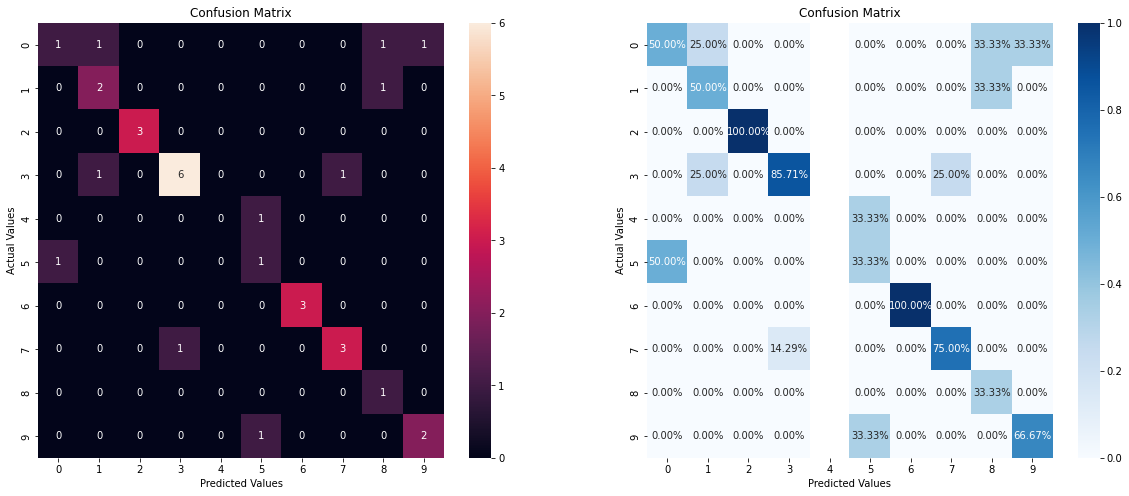

In [ ]:
# Vizualise the confusion matrix through seaborn library
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.subplot(1,2,2)
sns.heatmap(cm_df/np.sum(cm_df), annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

Looking at the confusion matrix, we realize that only 2 classes were correctly classified. All the other images have an erroneous prediction proportion. 

To make the study a little more precise we can calculate the precision, recall and f1-score indicators. To do this, we can display the classification report.

In [ ]:
print(Monkey_labels.columns)
Column = Monkey_labels.columns[2]

# Plotting a classification report
print('\nClassification Report:\n', classification_report(y_VAL, y_VAL_pred, target_names=Monkey_labels[Column]))


Index(['Label', '  Latin Name           ', ' Common Name                   ',
       ' Train Images ', ' Validation Images'],
      dtype='object')

Classification Report:
                                  precision    recall  f1-score   support

 mantled_howler                       0.50      0.25      0.33         4
 patas_monkey                         0.50      0.67      0.57         3
 bald_uakari                          1.00      1.00      1.00         3
 japanese_macaque                     0.86      0.75      0.80         8
 pygmy_marmoset                       0.00      0.00      0.00         1
 white_headed_capuchin                0.33      0.50      0.40         2
 silvery_marmoset                     1.00      1.00      1.00         3
 common_squirrel_monkey               0.75      0.75      0.75         4
 black_headed_night_monkey            0.33      1.00      0.50         1
 nilgiri_langur                       0.67      0.67      0.67         3

                      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


By observing the values calculated for precision and recall we notice that at best we obtain values of 0.70 for precision and 0.69 as recall which is clearly not sufficient. This implies that too many values are incorrectly predicted.

We remind that ideally we would like to obtain 1 for the precision and 1 for the recall in order to make f1-score also tend towards 1. It is clear that the performances of this model can be improved.

# 2 _ IMPROVED TRIAL

In order to improve these performances I propose to modify the architecture of the model and to enrich our dataset by using data augmetnation. To do this, I started by expanding the training dataset by making the images undergo a number of variations (rotation, inversion, zoom, ...), then I added a convolutional layer to my model, imposed a padding step to each layer, and finally, applied several time the dropout method. 

Note that the adaptations presented below are the result of many hours of research and testing in order to obtain better performances. 


° LOAD DATAS AND PREPROCESSING

In [ ]:
# Loading and Augmentation of the train dataset
Train_datagen = ImageDataGenerator(
      rescale=1. /255, 
      rotation_range=40, 
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2, 
      horizontal_flip=True
)

# Creation of the train data generator
It_Train = Train_datagen.flow_from_directory(
    Train_path,
    target_size=(256,256),
    batch_size=32,
    seed=123,
    shuffle=True,
    class_mode='categorical'
)

# Loading and Normalization of the test dataset
Val_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Creation of the test data generator
It_Val = Val_datagen.flow_from_directory(
    Val_path,
    target_size=(256, 256),
    batch_size=32,
    seed=123,
    shuffle=False,
    class_mode='categorical'
)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


° DEFINE MODEL

In [ ]:
model2 = Sequential()

model2.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu', padding='same', input_shape=(256, 256, 3)))
model2.add(MaxPooling2D())
model2.add(Dropout(0.2))

model2.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
model2.add(MaxPooling2D())
model2.add(Dropout(0.2))

model2.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
model2.add(MaxPooling2D())
model2.add(Dropout(0.2))

model2.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
model2.add(MaxPooling2D())
model2.add(Dropout(0.2))

model2.add(Flatten())

model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(10, activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 64)        0

° FIT/TRAIN MODEL

In [ ]:
hist2 = model2.fit_generator(It_Train, epochs=200, validation_data=It_Val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/200
35/35 [==============================] - 425s 12s/step - loss: 2.4251 - accuracy: 0.1011 - val_loss: 2.2944 - val_accuracy: 0.1103
Epoch 2/200
35/35 [==============================] - 64s 2s/step - loss: 2.3023 - accuracy: 0.1047 - val_loss: 2.2923 - val_accuracy: 0.1581
Epoch 3/200
35/35 [==============================] - 63s 2s/step - loss: 2.2761 - accuracy: 0.1339 - val_loss: 2.2388 - val_accuracy: 0.1728
Epoch 4/200
35/35 [==============================] - 65s 2s/step - loss: 2.2148 - accuracy: 0.1876 - val_loss: 2.1835 - val_accuracy: 0.1250
Epoch 5/200
35/35 [==============================] - 65s 2s/step - loss: 2.1142 - accuracy: 0.2222 - val_loss: 1.9722 - val_accuracy: 0.2831
Epoch 6/200
35/35 [==============================] - 65s 2s/step - loss: 2.1002 - accuracy: 0.2158 - val_loss: 2.0623 - val_accuracy: 0.2978
Epoch 7/200
35/35 [==============================] - 66s 2s/step - loss: 2.0442 - accuracy: 0.2304 - val_loss: 1.8734 - val_accuracy: 0.3125
Epoch 8/200

° DATA BACKUP

In [ ]:
# Save the model 2 as h5 file
#model2.save(os.path.join('/content/drive/MyDrive/Colab Notebooks/Monkey_Saved_Models', 'Monkey_Classifier_Model2.h5'))

# Save histrory of the model 2
#np.save('/content/drive/MyDrive/Colab Notebooks/Monkey_Saved_Models/hist2_model2.npy',hist2)


In [ ]:
# Load the model 2 saved 
#model2 = load_model('/content/drive/MyDrive/Colab Notebooks/Monkey_Saved_Models/Monkey_Classifier_Model2.h5')

# Load history model 2
#hist2 = np.load('/content/drive/MyDrive/Colab Notebooks/Monkey_Saved_Models/hist2_model2.npy',allow_pickle='TRUE').item()


° VISUALIZATION

In [ ]:
# Ultimate score visualization
score2 = model2.evaluate(It_Val, verbose=1)

print(f'Val loss: {score2[0]: 4.4f}')
print(f'Val accuracy: {score2[1]: 4.4f}')

9/9 [==============================] - 9s 873ms/step - loss: 0.5262 - accuracy: 0.8529
Val loss:  0.5262
Val accuracy:  0.8529


At the end of the training of this second model, we see that the values of loss and accuracy have improved well. Indeed, the loss goes from 2.15 to 0.52, and the accuracy from 68% to 85%. This is not too bad. 

However, by observing the evolution curves of these two metrics, we can see that the accuracy of the test dataset starts to stabilize after 100 iterations and that the loss of this same dataset starts to diverge at the same time. By continuing to train the model, we take the risk of overfitting. The model therefore reaches its limits quite quickly. 

The results presented remain more satisfactory than those obtained previously.

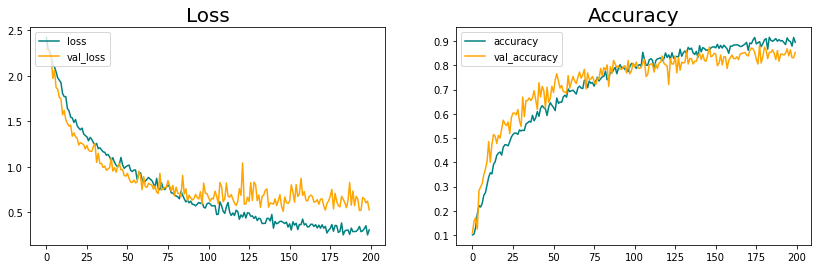

In [ ]:
plt.figure(figsize=(14,4))

# Loss visualization
plt.subplot(1,2,1)
plt.plot(hist2.history['loss'], color='teal', label='loss')
plt.plot(hist2.history['val_loss'], color='orange', label='val_loss')
plt.title('Loss', fontsize=20)
plt.legend(loc='upper left')

# Accuracy visualisation
plt.subplot(1,2,2)
plt.plot(hist2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist2.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.legend(loc='upper left')

plt.show()

° EVALUATION METRICS

In [ ]:
# Import and Normalize validation dataset for evaluation process
MD_Val2 = tf.keras.utils.image_dataset_from_directory(Val_path,seed=123, batch_size=32, image_size=(256, 256))
MD_Val_Normalized2 = MD_Val2.map(lambda x, y : (x/255, y))
X_VAL2, y_VAL2 = MD_Val_Normalized2.as_numpy_iterator().next() #next(MD_Val_Normalized)
#print(y_VAL)

Found 272 files belonging to 10 classes.


In [ ]:
y_VAL_pred2 = model2.predict(X_VAL2).argmax(axis=1)
cm2 = confusion_matrix(y_VAL2, y_VAL_pred2)
cm_df2 = pd.DataFrame(cm2)

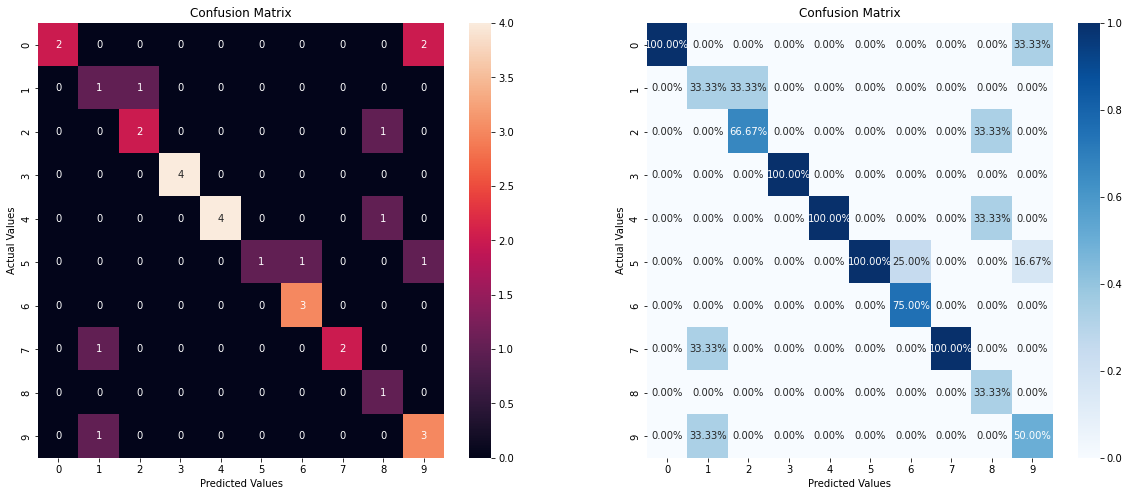

In [ ]:
# Vizualise the confusion matrix through seaborn library
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
sns.heatmap(cm_df2, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.subplot(1,2,2)
sns.heatmap(cm_df2/np.sum(cm_df2), annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

Contrary to the first model, this model is better able to distinguish the different classes. Indeed, by observing the confusion matrix, we notice that fewer classification errors are made. Here, 5 species are correctly classified although errors still occur on the others. 

In [ ]:
print(Monkey_labels.columns)
Column = Monkey_labels.columns[2]

# Plotting a classification report
print('\nClassification Report:\n', classification_report(y_VAL2, y_VAL_pred2, target_names=Monkey_labels[Column]))


Index(['Label', '  Latin Name           ', ' Common Name                   ',
       ' Train Images ', ' Validation Images'],
      dtype='object')

Classification Report:
                                  precision    recall  f1-score   support

 mantled_howler                       1.00      0.50      0.67         4
 patas_monkey                         0.33      0.50      0.40         2
 bald_uakari                          0.67      0.67      0.67         3
 japanese_macaque                     1.00      1.00      1.00         4
 pygmy_marmoset                       1.00      0.80      0.89         5
 white_headed_capuchin                1.00      0.33      0.50         3
 silvery_marmoset                     0.75      1.00      0.86         3
 common_squirrel_monkey               1.00      0.67      0.80         3
 black_headed_night_monkey            0.33      1.00      0.50         1
 nilgiri_langur                       0.50      0.75      0.60         4

                      

Displaying the classification report, we see that the precision has improved from 70% to 82%, which implies that the proportion of true positives among the number of positive images identified for each class has increased, so that our model makes fewer errors when predicting that an image belongs to a class. 

On the other hand, recall has only slightly increased from 69% to 72%. This means that the model was not able to correctly classify all images belonging to each class. 

Therefore, although the model performs better than the previous one, this performance does not seem to have changed that much since the f1-score only increased by 5% from 68% to 73%.

In short, although the performance of this model is not yet good enough, we can say that it is still a little better than the previous one. So let's try to improve its performance even more. 

# 3 _ ADVANCED TRIAL

Still with a view to improvement I wanted to apply some more trials modifying the architecture of the CNN model by adding a kernel initializer, varying the dropout values and by applying batchnormalization steps known to accelerate the learning process and to improve the results of the training. But it occured that this does not necessarily allow us to obtain better performances in a significant way.  

° DEFINE MODEL

In [ ]:
model3 = Sequential()

model3.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(256, 256, 3)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D())
model3.add(Dropout(0.2))

model3.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D())
model3.add(Dropout(0.2))

model3.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D())
model3.add(Dropout(0.3))

model3.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D())
model3.add(Dropout(0.4))

model3.add(Flatten())

model3.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))
model3.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
model3.add(Dense(10, activation='softmax'))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)    

° FIT/TRAIN MODEL

In [ ]:
hist3 = model3.fit_generator(It_Train, epochs=200, validation_data=It_Val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/200
35/35 [==============================] - 74s 2s/step - loss: 2.3052 - accuracy: 0.2605 - val_loss: 3.2561 - val_accuracy: 0.1581
Epoch 2/200
35/35 [==============================] - 70s 2s/step - loss: 1.8941 - accuracy: 0.3342 - val_loss: 7.9832 - val_accuracy: 0.1029
Epoch 3/200
35/35 [==============================] - 70s 2s/step - loss: 1.7302 - accuracy: 0.3889 - val_loss: 4.3386 - val_accuracy: 0.1765
Epoch 4/200
35/35 [==============================] - 70s 2s/step - loss: 1.6265 - accuracy: 0.4372 - val_loss: 7.9846 - val_accuracy: 0.1250
Epoch 5/200
35/35 [==============================] - 70s 2s/step - loss: 1.5659 - accuracy: 0.4599 - val_loss: 7.3533 - val_accuracy: 0.1507
Epoch 6/200
35/35 [==============================] - 69s 2s/step - loss: 1.5769 - accuracy: 0.4454 - val_loss: 10.0949 - val_accuracy: 0.1324
Epoch 7/200
35/35 [==============================] - 70s 2s/step - loss: 1.4859 - accuracy: 0.4745 - val_loss: 9.0114 - val_accuracy: 0.1360
Epoch 8/200


° DATA BACKUP

In [ ]:
# Save the model 3 as h5 file
#model3.save(os.path.join('/content/drive/MyDrive/Colab Notebooks/Monkey_Saved_Models', 'Monkey_Classifier_Model3.h5'))

# Save histrory of the model 3
#np.save('/content/drive/MyDrive/Colab Notebooks/Monkey_Saved_Models/hist3_model3.npy',hist3)

In [ ]:
# Load the model 3 saved 
#model3 = load_model('/content/drive/MyDrive/Colab Notebooks/Monkey_Saved_Models/Monkey_Classifier_Model3.h5')

# Load history model 3
#hist3 = np.load('/content/drive/MyDrive/Colab Notebooks/Monkey_Saved_Models/hist3_model3.npy',allow_pickle='TRUE').item()

° VISUALIZATION

In [ ]:
# ultimate score visualization
score3 = model3.evaluate(It_Val, verbose=1)

print(f'Val loss: {score3[0]: 4.4f}')
print(f'Val accuracy: {score3[1]: 4.4f}')

9/9 [==============================] - 9s 920ms/step - loss: 1.5957 - accuracy: 0.6250
Val loss:  1.5957
Val accuracy:  0.6250


At the end of the training of this third model, we could have expected that the performances would be better, in particular by the use of kernel initializer and batchormalization, but it turns out that the performances presented are lower than those proposed by the second model. 

Moreover, by observing the loss and accuracy curves, we notice a difference (gap) between the values given by the training dataset and those given by the testing dataset. Indeed, this may be due to the fact that the batchnormalization function does not have the same behavior with the two datasets. Therefore, although the predicted and real data seem to have the same trend, it is complicated to evaluate if the predicted data match the real data. 

In terms of values, the loss seems to be positioned between the values obtained by the two previous models while the accuracy is much lower. 

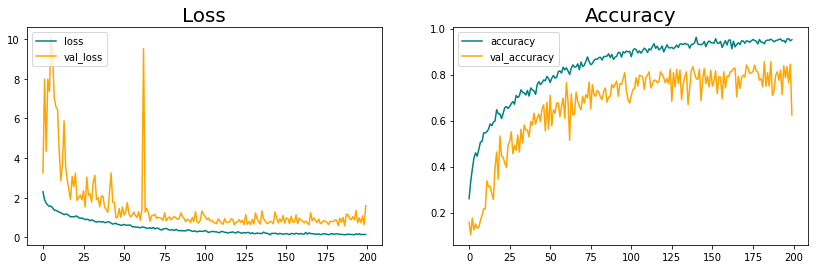

In [ ]:
plt.figure(figsize=(14,4))

# Loss visualization
plt.subplot(1,2,1)
plt.plot(hist3.history['loss'], color='teal', label='loss')
plt.plot(hist3.history['val_loss'], color='orange', label='val_loss')
plt.title('Loss', fontsize=20)
plt.legend(loc='upper left')

# Accuracy visualisation
plt.subplot(1,2,2)
plt.plot(hist3.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist3.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.legend(loc='upper left')

plt.show()

° EVALUATION METRICS

In [ ]:
# Import and Normalize validation dataset for evaluation process
MD_Val3 = tf.keras.utils.image_dataset_from_directory(Val_path,seed=123, batch_size=32, image_size=(256, 256))
MD_Val_Normalized3 = MD_Val3.map(lambda x, y : (x/255, y))
X_VAL3, y_VAL3 = MD_Val_Normalized3.as_numpy_iterator().next() #next(MD_Val_Normalized)
#print(y_VAL)

Found 272 files belonging to 10 classes.


In [ ]:
y_VAL_pred3 = model3.predict(X_VAL3).argmax(axis=1)
cm3 = confusion_matrix(y_VAL3, y_VAL_pred3)
cm_df3 = pd.DataFrame(cm3)

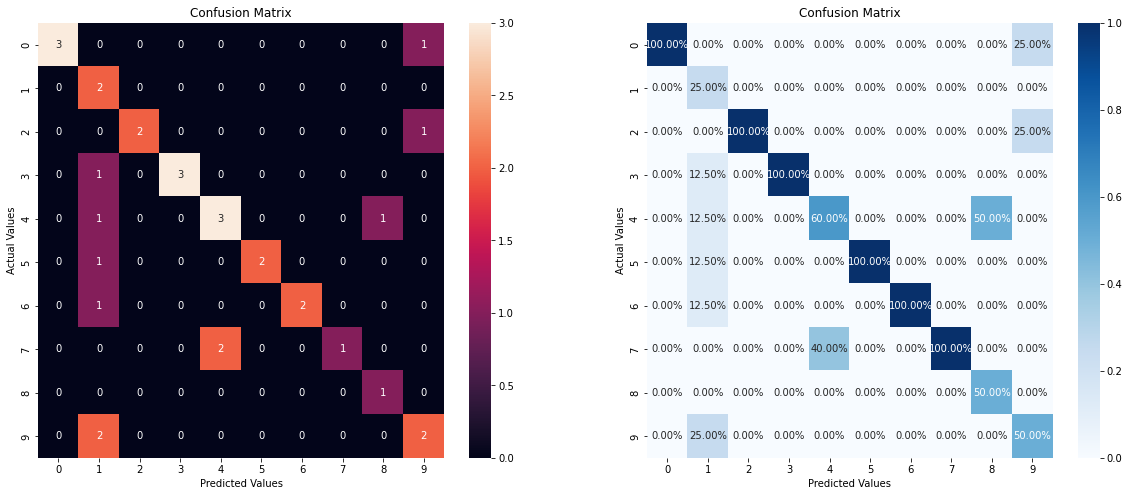

In [ ]:
# Vizualise the confusion matrix through seaborn library
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
sns.heatmap(cm_df3, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.subplot(1,2,2)
sns.heatmap(cm_df3/np.sum(cm_df3), annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

Paradoxically, when looking at the confusion matrix, one is surprised to see that more classes are correctly predicted. This is in contrast with the accuracy presented by our third model. Perhaps it is to the images selected in our validation dataset, another arrangement could give us different values. 

In [ ]:
print(Monkey_labels.columns)
Column = Monkey_labels.columns[2]

# Plotting a classification report
print('\nClassification Report:\n', classification_report(y_VAL3, y_VAL_pred3, target_names=Monkey_labels[Column]))


Index(['Label', '  Latin Name           ', ' Common Name                   ',
       ' Train Images ', ' Validation Images'],
      dtype='object')

Classification Report:
                                  precision    recall  f1-score   support

 mantled_howler                       1.00      0.75      0.86         4
 patas_monkey                         0.25      1.00      0.40         2
 bald_uakari                          1.00      0.67      0.80         3
 japanese_macaque                     1.00      0.75      0.86         4
 pygmy_marmoset                       0.60      0.60      0.60         5
 white_headed_capuchin                1.00      0.67      0.80         3
 silvery_marmoset                     1.00      0.67      0.80         3
 common_squirrel_monkey               1.00      0.33      0.50         3
 black_headed_night_monkey            0.50      1.00      0.67         1
 nilgiri_langur                       0.50      0.50      0.50         4

                      

Finally, if we look at the precision of this third model we see that the precision is not so bad, 81%, while the recall is only 66%. According to the f1-score of 69%, this model is not more efficient despite the modifications made. 

In the end, the second model proposed remains the best performing model that I was able to propose for this exercise. 

**CONCLUSION**

In conclusion, this exercise allowed me to test and propose different neural network convolution (CNN) architectures in order to classify images of monkeys belonging to 10 different species. 
The best performance reached in the time limit attributed to this project is 85% for the second model. This means that the model has an 85% chance of correctly assigning an image of a monkey to the right species. 

With regard to the improvement, I could not test much more complex models due to the lack of time and computing power available to me, but I suggest that by using defining more complexe network and/or using methods like transfer learning, fine-tunin and grid-search, it is quite possible to define a much better performing model.